<h1>Sales Data Analysis and Forcasting</h1>
<P>This project mainly focuse on the <b>time series analysis and forcasting</b>. I have collected 'Rossmann Store Sales' data from <a href="https://www.kaggle.com/c/rossmann-store-sales">Kaggle</a></P>

<ul>
    <li><a href="#1" style="text-decoration: none;">Exploratory Data Analysis</a></li>
    <li><a href="#2" style="text-decoration: none;">ECDF: empirical cumulative distribution function</a></li>
    <li><a href="#3" style="text-decoration: none;">Missing values</a></li>
    <li><a href="#4" style="text-decoration: none;">Store types</a></li>
    <li><a href="#5" style="text-decoration: none;">Correlational Analysis</a></li>
    <li><a href="#6" style="text-decoration: none;">Conclusion of EDA</a></li>
    <li><a href="#7" style="text-decoration: none;">Time-Series Analysis per Store Type</a></li>
    <li><a href="#8" style="text-decoration: none;">Seasonality</a></li>
    <li><a href="#9" style="text-decoration: none;">Yearly trend</a></li>
    <li><a href="#10" style="text-decoration: none;">Autocorrelaion</a></li>
    <li><a href="#11" style="text-decoration: none;">Time Series Analysis and Forecasting with Prophet</a></li>
    <li><a href="#12" style="text-decoration: none;">Modeling Holidays</a></li>
    <li><a href="#13" style="text-decoration: none;">Conclusion of Time Series forecasting</a></li>
</ul>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.distributions.empirical_distribution import ECDF

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from prophet import Prophet

In [2]:
train = pd.read_csv('Data/train.csv', parse_dates=True, low_memory=False, index_col='Date')
store = pd.read_csv('Data/store.csv', low_memory=False)
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

<h1 id='1'>Exploratory Data Analysis</h1>
<p>In this section we will explore the missing value of train and store data. Then I will create a new feature for furture analysis</p>

In [3]:
print('Total :', train.shape)
train.head(5)

Total : (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


<b><i>Sort Description about train data</i></b>
<ul>
    <li><i>Store</i>: Indicate the store number</li>
    <li><i>DayOfWeek</i>: Day number in a week</li>
    <li><i>Sales</i>: Daily Sales</li>
    <li><i>Customers</i>: Number of castomer in a day</li>
    <li><i>Open</i>: The store is open or not. 0 for closed and 1 for Open</li>
    <li><i>Promo</i>: The store is runing any promotion in that day. 0 for not and 1 for Yes</li>
    <li><i>StateHoliday</i>: Indicate State Holiday was or not. 0 for not and 1 for Yes</li>
    <li><i>SchoolHoliday</i>: Indicate School Holiday was or not. 0 for not and 1 for Yes</li>
</ul>
<p>Since we are dealing with time series analysis, so it is importatn to note all of the things</p>

In [4]:
train['Day'] = train.index.day
train['Month'] = train.index.month
train['Year'] = train.index.year
train['Weekofyear'] = train.index.weekofyear
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train.head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Weekofyear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,31,7,2015,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,31,7,2015,31,9.702400


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Store             1017209 non-null  int64  
 1   DayOfWeek         1017209 non-null  int64  
 2   Sales             1017209 non-null  int64  
 3   Customers         1017209 non-null  int64  
 4   Open              1017209 non-null  int64  
 5   Promo             1017209 non-null  int64  
 6   StateHoliday      1017209 non-null  object 
 7   SchoolHoliday     1017209 non-null  int64  
 8   Day               1017209 non-null  int64  
 9   Month             1017209 non-null  int64  
 10  Year              1017209 non-null  int64  
 11  Weekofyear        1017209 non-null  int64  
 12  SalesPerCustomer  844340 non-null   float64
dtypes: float64(1), int64(11), object(1)
memory usage: 108.6+ MB


In [6]:
NullCheck = train[train['SalesPerCustomer'].isnull()]
NullCheck.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Weekofyear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,31,7,2015,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,31,7,2015,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,30,7,2015,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,30,7,2015,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,29,7,2015,31,NaN


In [7]:
NullCheck['Customers'].unique()

array([0], dtype=int64)

In [8]:
NullCheck['Sales'].unique()

array([0], dtype=int64)

In [9]:
NullCheck = train[train['SalesPerCustomer'] == 0]
NullCheck.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Weekofyear,SalesPerCustomer
Date,,,,,,,,,,,,,
2014-04-29,1100,2,0,3,1,1,0,0,29,4,2014,18,0.0
2013-04-25,948,4,0,5,1,1,0,0,25,4,2013,17,0.0


<p>Most of the SalesPerCustomer value is zero, neither did not sales at that day nor none of the customer did not come to buy. We need filter Zero Customer and Sales from the train dataset</p>

In [10]:
train[(train['Sales'] != 0) & (train['Customers'] != 0)].shape

(844338, 13)

In [11]:
train['SalesPerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

<p>As we can see, some of the day did not sales or customer did not come. And maximum Sales per Customer ~65. Since std is ~2.2 we can say most of the value is near ~9.49.</p>
<h3 id='2'>ECDF: empirical cumulative distribution function</h3>

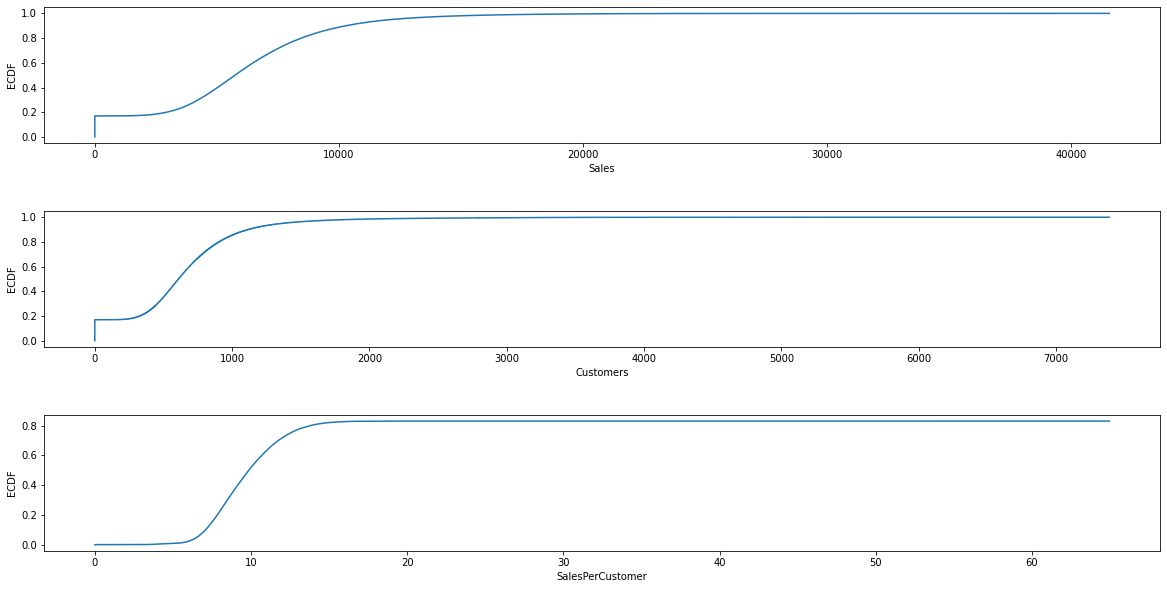

In [12]:
plt.figure(figsize=(20,10))
fnum = 311
variable = ['Sales', 'Customers', 'SalesPerCustomer']
for x in variable:
    plt.subplot(fnum)
    plt.subplots_adjust(hspace=0.5)
    cdf = ECDF(train[x])
    plt.plot(cdf.x, cdf.y, label='statmodels')
    plt.xlabel(x); plt.ylabel('ECDF');
    fnum=fnum + 1

<p>Almost 20% of data was zero sales/ Castomer and 80% of time selas less than 1000. So we have to undesrtand, why 20% are zero sales</p>
<h3 id='3'>Missing values</h3>
<p>There're 172817 closed stores in the data. we need to avoid any biased during forecasts, this is why we will drop these  zero values. Let check the others, where the store is open but did not sales.</p>

In [13]:
train['Open'].unique()

array([1, 0], dtype=int64)

In [14]:
train[(train['Sales'] == 0) & (train['Open'] == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Weekofyear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,31,7,2015,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,31,7,2015,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,30,7,2015,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,30,7,2015,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,29,7,2015,31,NaN


In [15]:
not_seal = train[(train['Open'] != 0) & (train['Sales'] == 0)]
not_seal.shape

(54, 13)

There are 54 days did not sales any product, I think there are another resone. Let's continue our analysis.</p>

In [111]:
train = train[(train['Sales'] != 0) & (train['Customers'] != 0)]
train.shape

(844338, 13)

</p><b>Let's analysis the store data</b></p>

In [17]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [18]:
store.shape

(1115, 10)

In [19]:
store['Store'].unique()

array([   1,    2,    3, ..., 1113, 1114, 1115], dtype=int64)

<b><i>Sort Description about store data</i></b>
<ul>
    <li><i>Store</i>: Have an unique ID for each store</li>
    <li><i>StoreType</i>: Four different types of store (a, b, c, d)</li>
    <li><i>Assortment</i>: Lavel: a = Basic, b = Extra, C = Extended</li>
    <li><i>CompetitionDistance</i>: Distance in meters to identify nearest competiitor. </li>
    <li><i>CompetitionOpenSinceMonth</i>: Nerest competitor open their store in a month.</li>
    <li><i>CompetitionOpenSinceYear</i>: Nerest competitor open their store in a year.</li>
    <li><i>Promo2</i>: 0 for store did not perticiate, 1 for did.</li>
    <li><i>Promo2SinceWeek</i>: Describe the weekly time to reperesent the store perticipation.</li>
    <li><i>Promo2SinceYear</i>: Describe the yearly time to reperesent the store perticipation.</li>
    <li><i>PromoInterval</i>: Promotional round starts in February, May, August, November of any given year for that store</li>
</ul>

In [20]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

<p>As we can see their are some value are missing. We have to deal with this missing value. Let's start with <i>CompetitionDistance</i> values.</p>

In [21]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [22]:
store['Promo2'].unique()

array([0, 1], dtype=int64)

In [23]:
store[store['CompetitionDistance'].isnull() & (store['Promo2'] == 1)].shape

(0, 10)

<p>If no promotion, that's mean thire are no infomation. we can replace it with 0 value</p>

In [24]:
store.fillna(0, inplace = True)
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [25]:
len(train['Store'].unique())

1115

In [26]:
len(store['Store'].unique())

1115

<p><b>Merge the two data set for analysis purpose.</b></p>

In [27]:
train_store = pd.merge(train, store, how='inner', on='Store')
train_store.shape

(844338, 22)

In [28]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,31,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,30,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,29,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,28,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,27,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


<h3 id='4'>Store types</h3>

In [29]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


<p>In description, we can see most of the sales in storeType <i>a</i>. And less dispersion  of data in <i>d</i> Storetype. On other hand, most everage sales in storeType <i>b</i></p>

In [30]:
train_store.groupby('StoreType')['Sales', 'Customers'].sum()

,Sales,Customers
StoreType,,
a,3165334859,363541431
b,159231395,31465616
c,783221426,92129705
d,1765392943,156904995


<p>Clearly stores of type A. StoreType D goes on the second place in both Sales and Customers. What about date periods?</p>

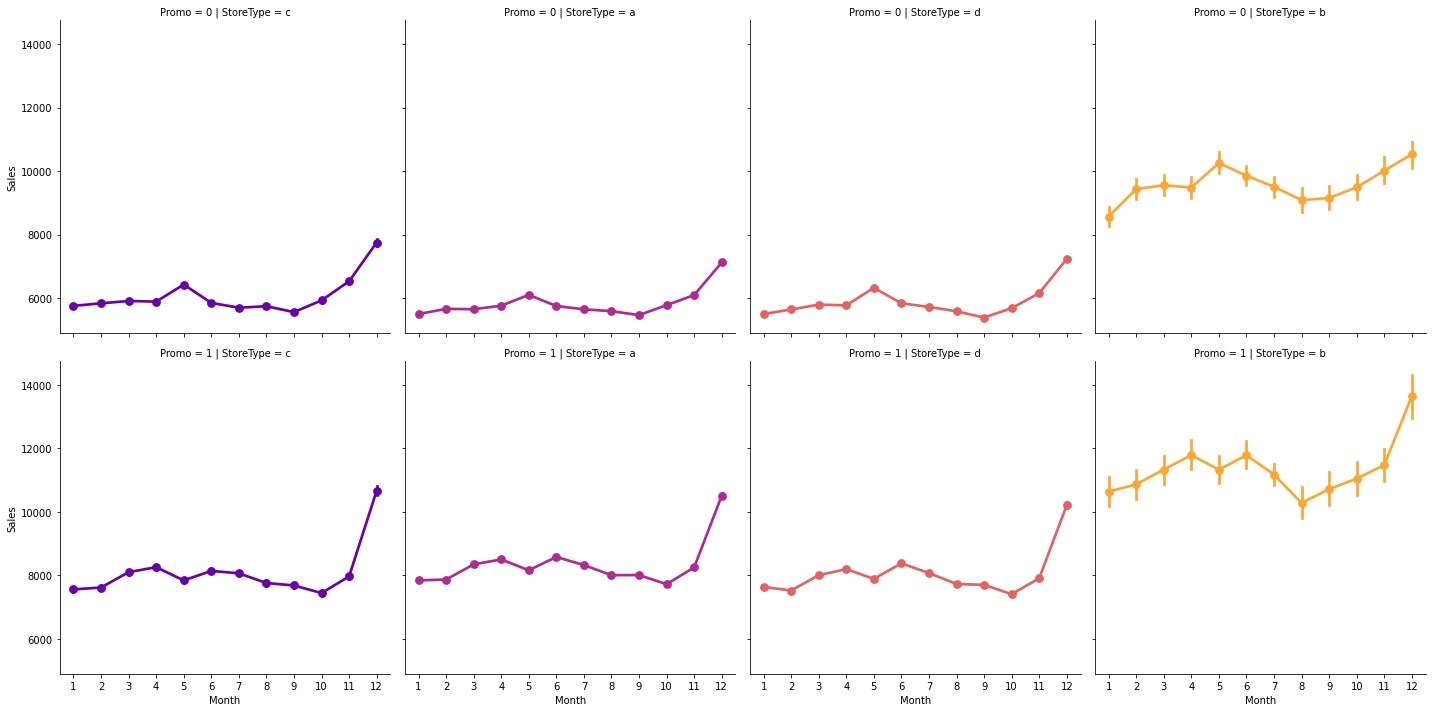

In [31]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
              col = 'StoreType',
              palette = 'plasma',
              hue = 'StoreType',
              row = 'Promo')
plt.show()

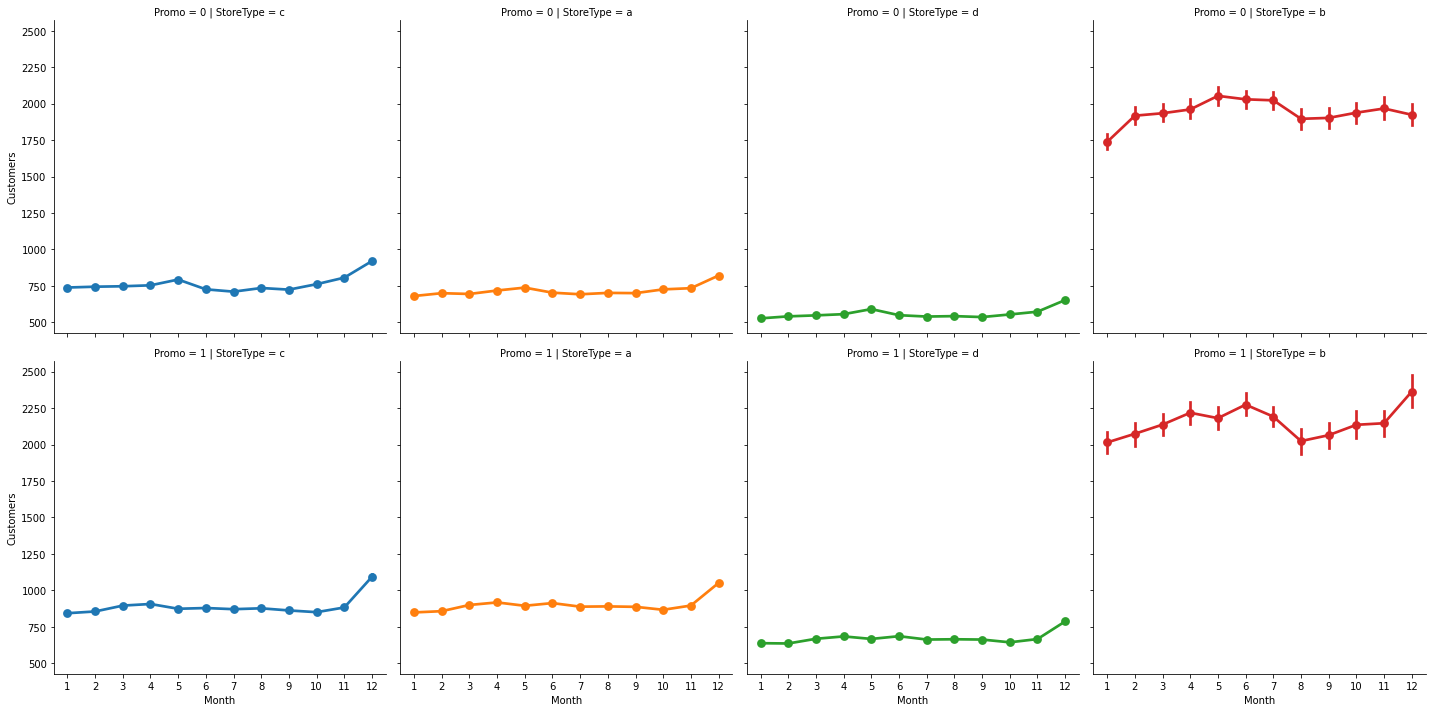

In [32]:
sns.factorplot(data=train_store, x='Month', y = 'Customers',
              col = 'StoreType',
              pattern='plasma',
              hue = 'StoreType',
              row = 'Promo')
plt.show()

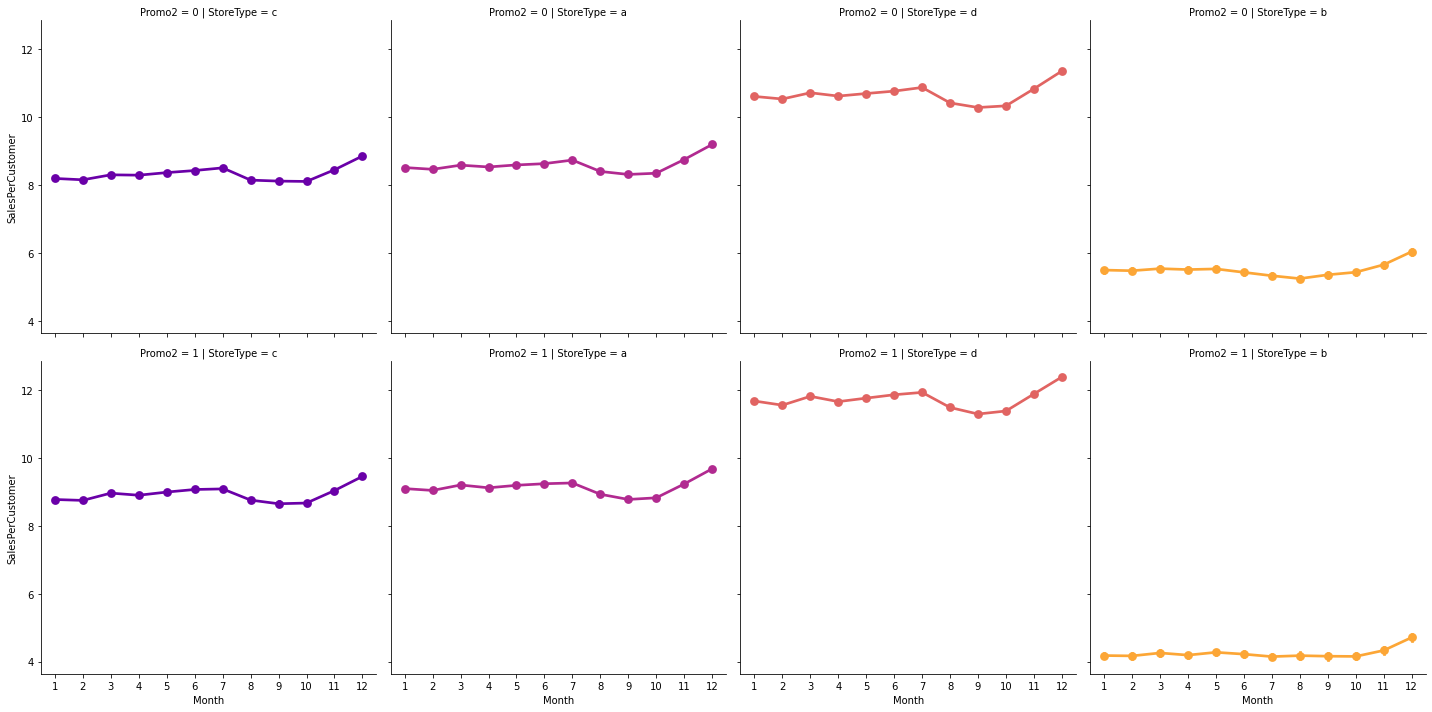

In [33]:
sns.factorplot(data = train_store, x='Month', y = 'SalesPerCustomer',
              col='StoreType',
              palette = 'plasma',
              hue = 'StoreType',
              row = 'Promo2')
plt.show()

<p>All store types follow the same trend. But pretty different between without promotion and with promotion.</p>

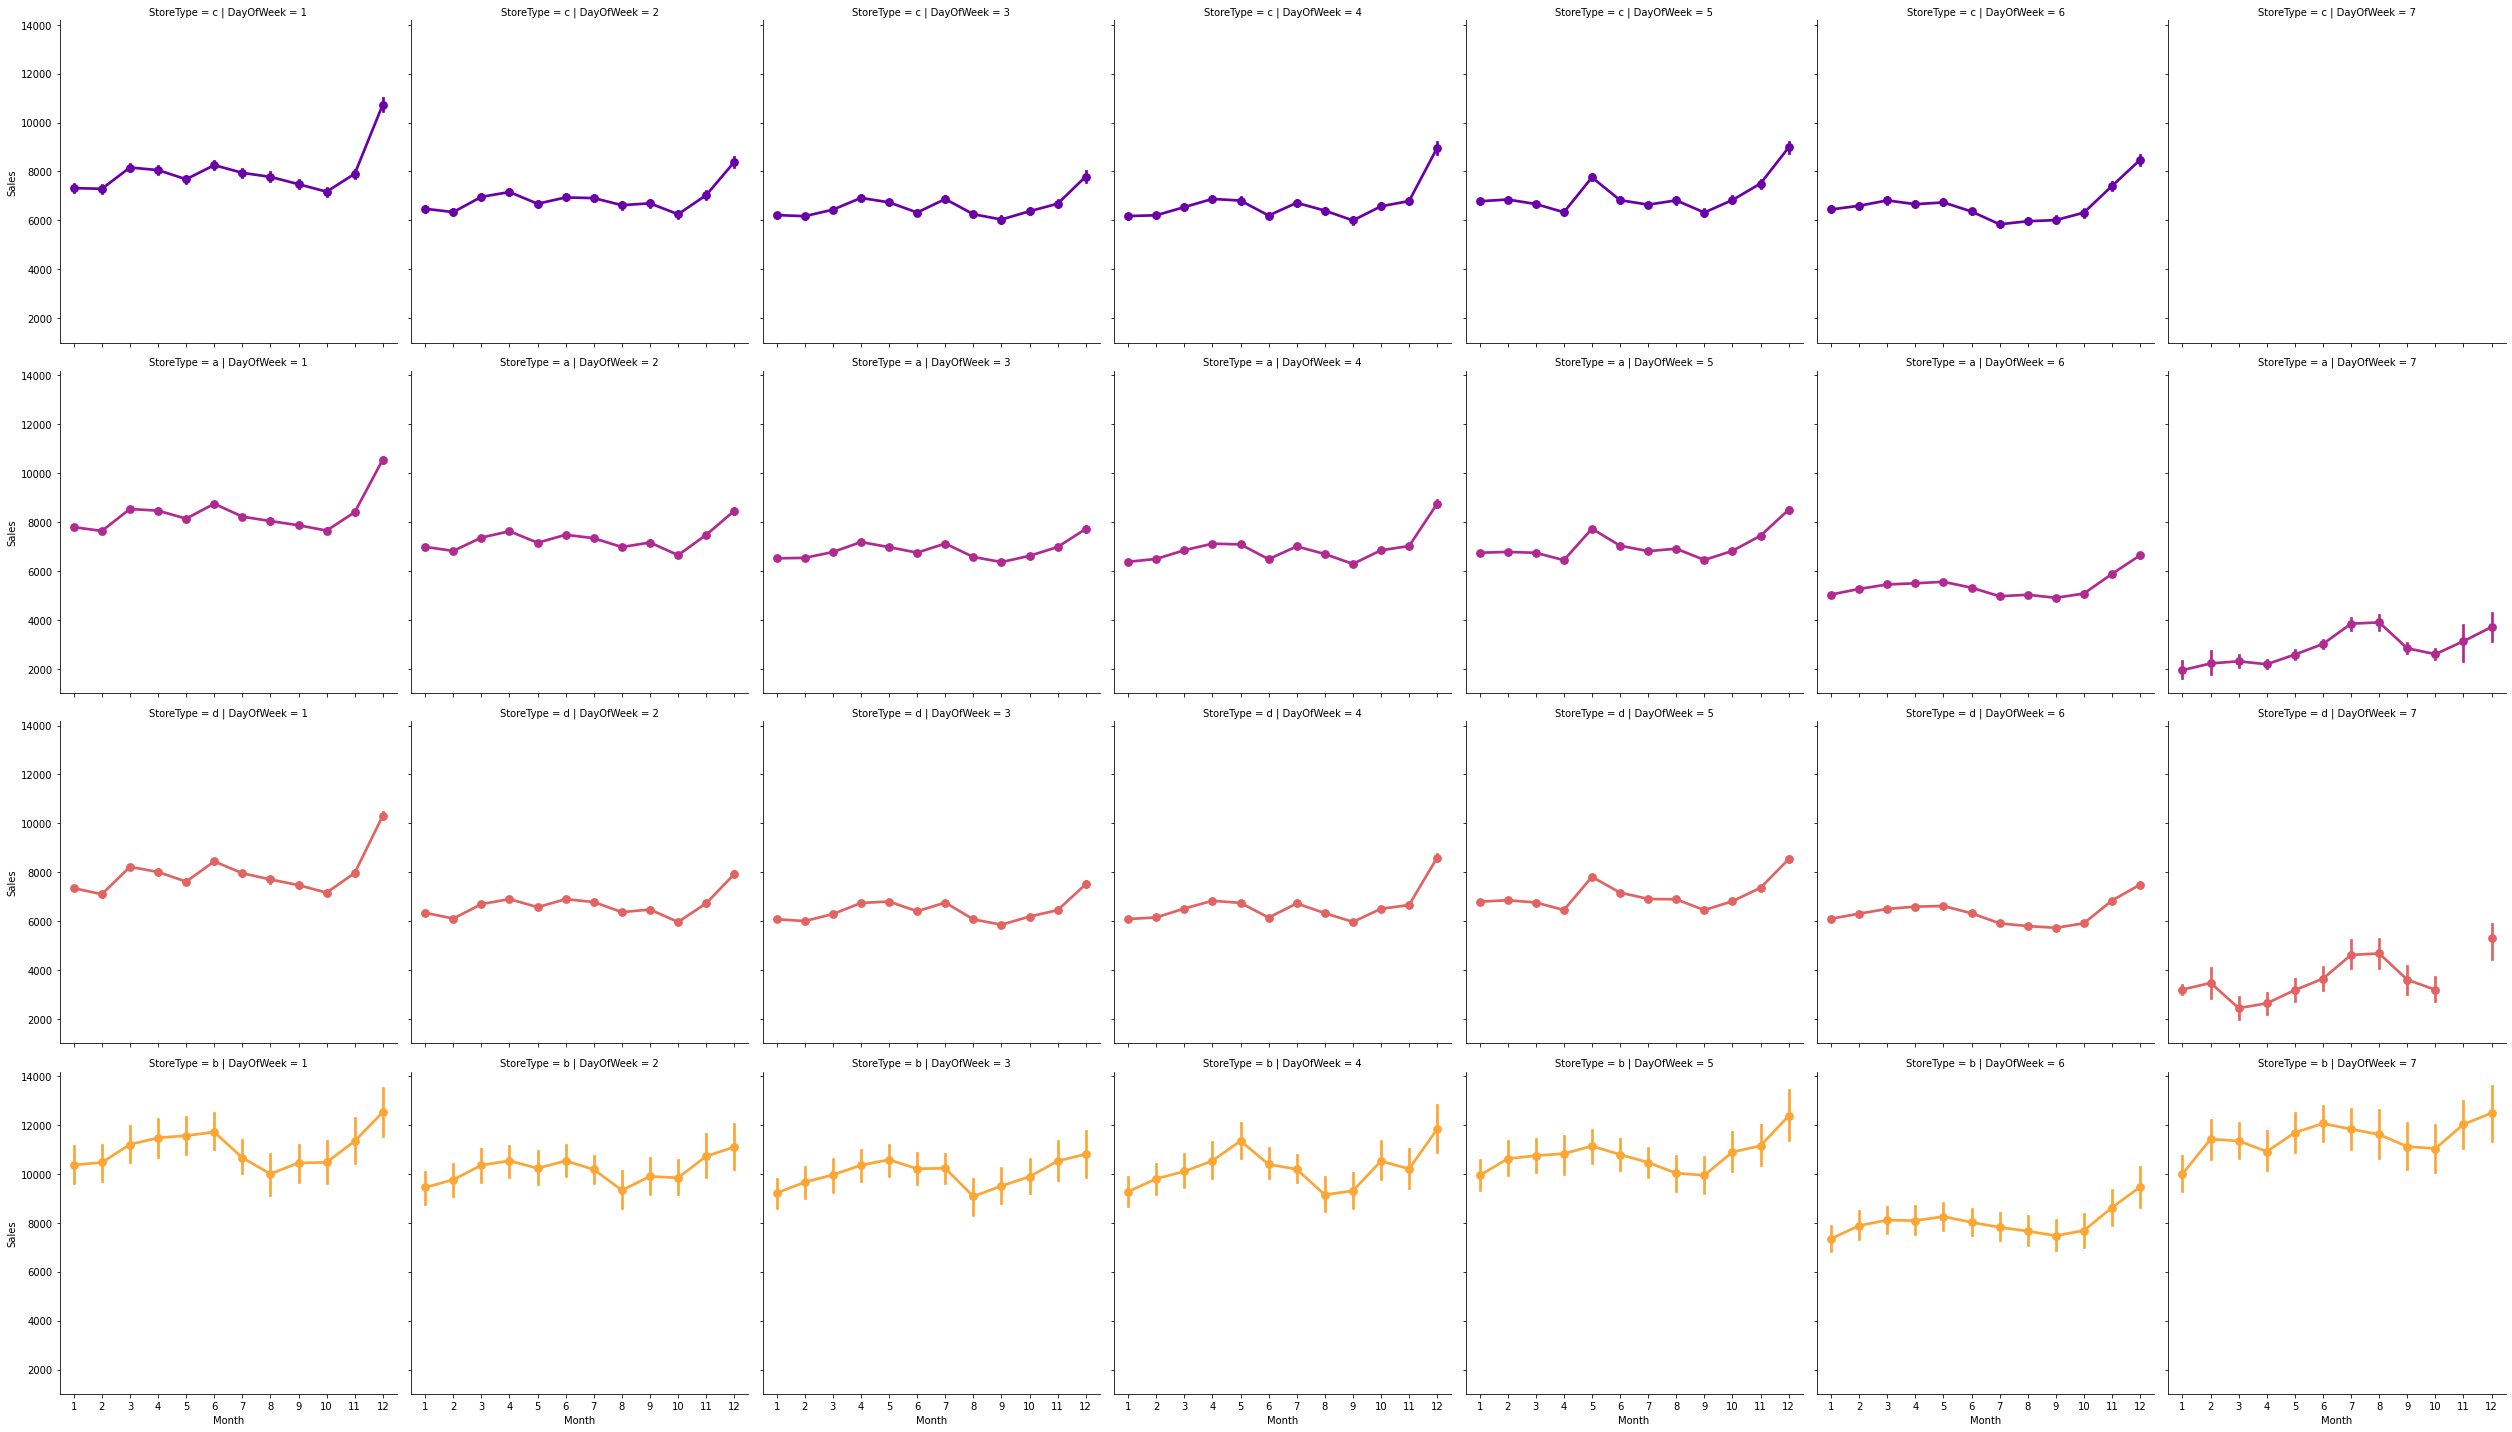

In [34]:
sns.factorplot(data=train_store, x = 'Month', y = 'Sales',
              col = 'DayOfWeek',
              palette = 'plasma',
              hue = 'StoreType',
              row = 'StoreType')
plt.show()

<p>Although all of the type follow almost same trend. we can see from visualization, most of the sales do better at the end of the day. And most of the seles in storeType b</p>

In [35]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.Weekofyear - train_store.Promo2SinceWeek) / 4.0

In [36]:
train_store.loc[train_store['Promo2SinceYear'] == 0, 'PromoOpen'] = 0
pd.set_option('display.max_columns', None)
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Weekofyear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen
0,1,5,5263,555,1,1,0,1,31,7,2015,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,0.0
1,1,4,5020,546,1,1,0,1,30,7,2015,31,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,0.0
2,1,3,4782,523,1,1,0,1,29,7,2015,31,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,0.0
3,1,2,5011,560,1,1,0,1,28,7,2015,31,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,0.0
4,1,1,6102,612,1,1,0,1,27,7,2015,31,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,0.0


In [37]:
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,10.958105,7115.514452
b,10233.380141,2022.211825,3.717593,11364.495244
c,6933.126425,815.538073,13.964386,6745.418694
d,6822.300064,606.353935,14.827699,9028.526526


<p>The most selling and crowded StoreType A doesn't appear to be the one the most exposed to competitors. Instead it's a StoreType B, which also has the longest running period of promotion.</p>

In [1]:
<h3 id='5'>Correlational Analysis</h3>

SyntaxError: invalid syntax (<ipython-input-1-2a277d740d74>, line 1)

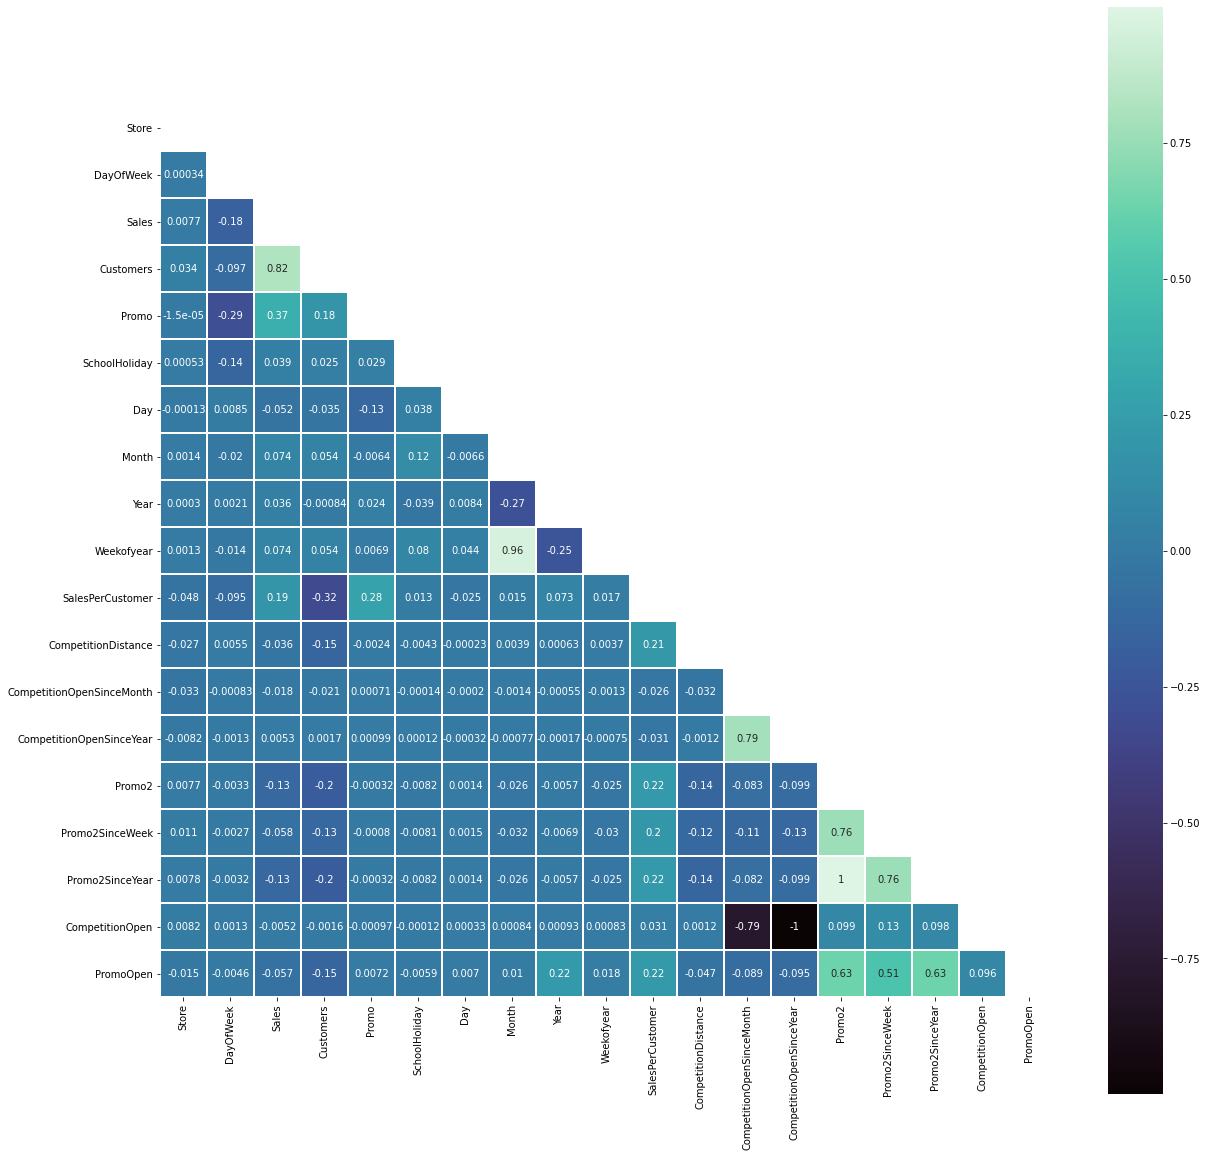

In [38]:
corr_all = train_store.drop('Open', axis=1).corr()
plt.figure(figsize=(20, 20))
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_all, cmap='mako', mask = mask, annot = True, linewidths= .2, square=True)
plt.show()

<p>The heatmap is showing that a strong correlation between sales and customer.</p>

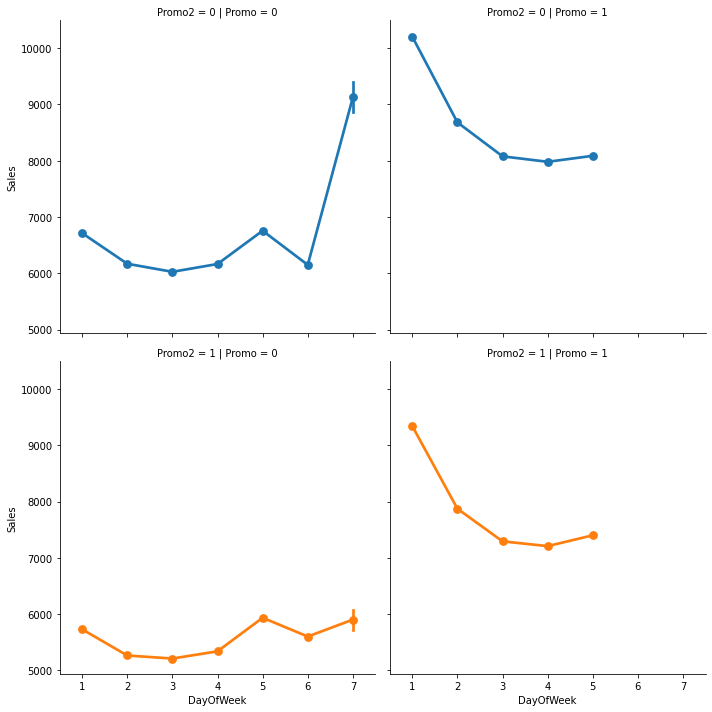

In [39]:
sns.factorplot(data=train_store, x = 'DayOfWeek', y = 'Sales',
              col='Promo',
              row = 'Promo2',
              hue = 'Promo2')
plt.show()

<p>In case of no promotion, Sales tend to peak on Sunday. Though we should note that StoreType C doesn't work on Sundays. So it is mainly data from StoreType A, B and D. On the contrary, stores that run the promotion tend to make most of the Sales on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores where bosth promotion run in same time.</p>
<h3 id='6'>Conclusion of EDA</h3>
<ul>
    <li>Most sales StoreType is A</li>
    <li>The best "Sale per Customer" StoreType is D</li>
    <li>Low "Sale per Customer" amount StoreType is B</li>
    <li>Customers tends to buy more on Modays when one promotion is running and on Sundays when there's no promotion run.</li>
</ul>

<h3 id='7'>Time-Series Analysis per Store Type</h3>
<p>What does mean of Time-Series?</p>
<p>Time series analysis, a time series is modeled to determine its components in terms of seasonal patterns, trends, relation to external factors. In other hand, time series forecasting uses the information in a time series to forecast future values of that series.</p>
<p>I am building a time series analysis on store types instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonalities in the dataset.</p>
<h3 id='8'>Seasonality</h3>
<p>Here I will take four stores types to understand the group</p>
<ul>
    <li>Store number 2 for <i>StoreType A</i></li>
    <li>Store number 85 for <i>StoreType B</i></li>
    <li>Store number 1 for <i>StoreType C</i></li>
    <li>Store number 14 for <i>StoreType D</i></li>
<ul>

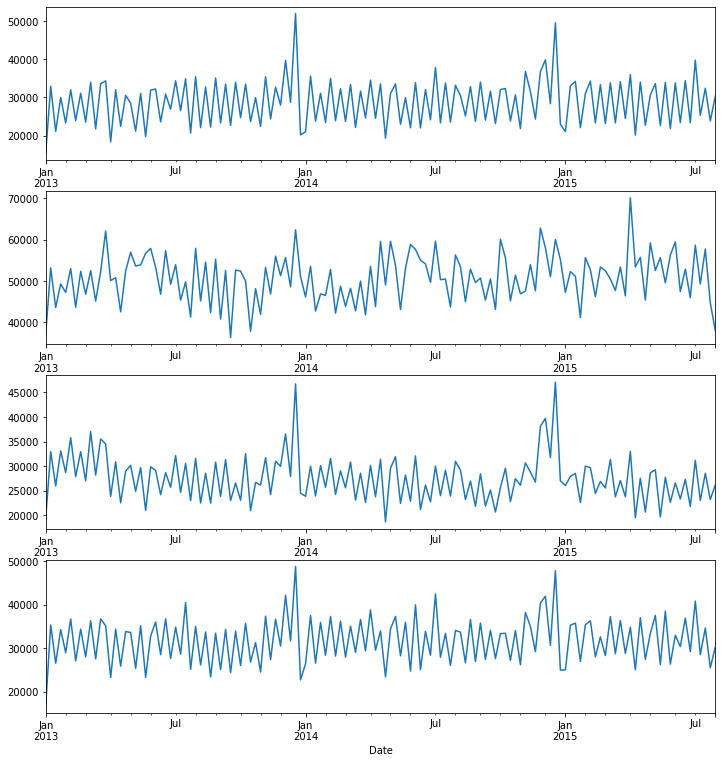

In [48]:
# preparation: input should be float type
train['Sales'] = train['Sales'].astype(float)

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True)
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 14]['Sales'].sort_index(ascending = True)

f, (axa, axb, axc, axd) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(ax = axa)
sales_b.resample('W').sum().plot(ax = axb)
sales_c.resample('W').sum().plot(ax = axc)
sales_d.resample('W').sum().plot(ax = axd)
plt.show()

<p>Retail sales for StoreType A and C tend to peak for the Christmas season and then decline after the holidays.</p>
<h3 id='9'>Yearly trend</h3>
<p>Retail sales for StoreType A and C tend to peak for the Christmas season and then decline after the holidays.</p>

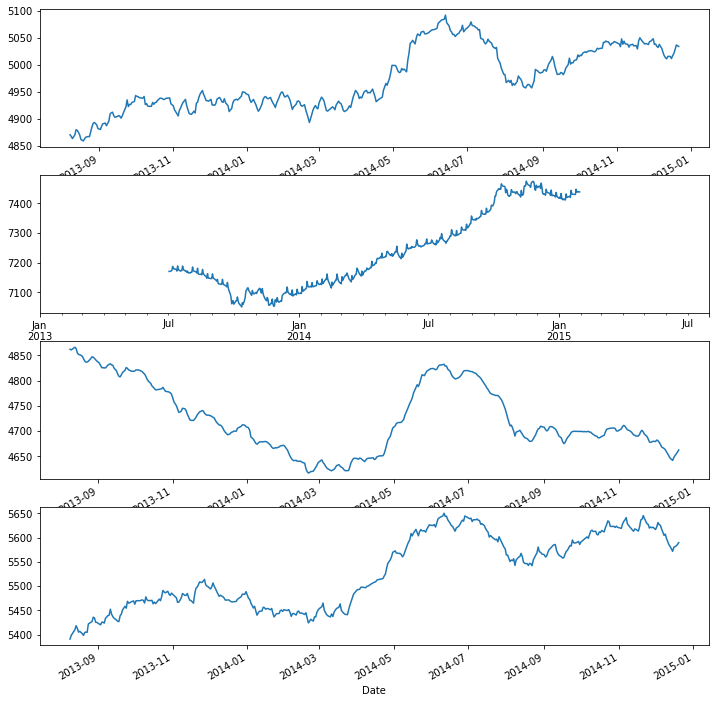

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
f, (axa, axb, axc, axd) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(ax = axa)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(ax = axb)

decomposition_c = seasonal_decompose(sales_c, model='additive', freq = 365)
decomposition_c.trend.plot(ax=axc)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(ax = axd)
plt.show()

<p>Overall sales seems increasing. But in StoreType C is shwoing the sales in decrease sequentially. It could not back to the previous point</p>
<h3 id='10'>Autocorrelaion</h3>
<p>The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.</p>
<p><b>ACF</b> is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. In simple terms, it describes how well the present value of the series is related with its past values. On toher the hand,<b>PACF</b> is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation.</p>

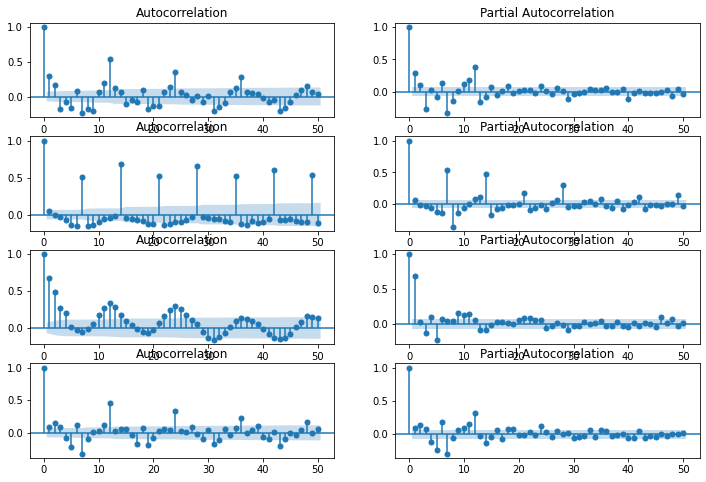

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plt.figure(figsize=(12, 8))
plt.subplot(421)
plot_acf(sales_a, lags=50, ax = plt.gca())
plt.subplot(422)
plot_pacf(sales_a, lags=50, ax = plt.gca())

plt.subplot(423)
plot_acf(sales_b, lags=50, ax = plt.gca())
plt.subplot(424)
plot_pacf(sales_b, lags=50, ax = plt.gca())

plt.subplot(425)
plot_acf(sales_c, lags=50, ax=plt.gca())
plt.subplot(426)
plot_pacf(sales_c, lags = 50, ax=plt.gca())

plt.subplot(427)
plot_acf(sales_d, lags=50, ax=plt.gca())
plt.subplot(428)
plot_pacf(sales_d, lags=50, ax=plt.gca())
plt.show()

<p>Type A and type B: Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags.Additionally, in Type C and type D: Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations.</p>
<h2 id='11'>Time Series Analysis and Forecasting with Prophet</h2>
<p>The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called Prophet. We have observed two main themes in the practice of creating a variety of business forecasts:</p>
<ul>
    <li>Completely automatic forecasting techniques can be brittle and they are often too inflexible to incorporate useful assumptions or heuristics.</li>
    <li>Analysts who can produce high quality forecasts are quite rare because forecasting is a specialized data science skill requiring substantial experience.</li>
<ul>

In [70]:
data = pd.read_csv('Data/train.csv')
data = data[(data['Open'] != 0) & (data['Open'] != 0)]
sales = data[data.Store == 1].loc[:, ['Date', 'Sales']]
sales = sales.sort_index(ascending = False)
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales = sales.rename(columns = {'Date': 'ds', 'Sales':'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


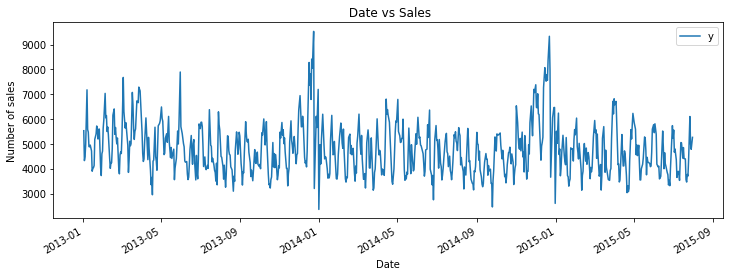

In [77]:
sales.set_index('ds').plot(figsize=(12, 4))
plt.title(' Date vs Sales')
plt.xlabel('Date')
plt.ylabel('Number of sales')
plt.show()

<h3 id='12'>Modeling Holidays</h3>
<p>Prophet also allows to model for holidays, and that's what we do here.</p>

In [94]:
stateHoliday = data[(data['StateHoliday'] == 'a') | (data['StateHoliday'] == 'b') | (data['StateHoliday'] == 'c')].loc[:, 'Date'].values
schoolHoliday = data[data['SchoolHoliday'] == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'stateHoliday', 'ds': pd.to_datetime(stateHoliday)})
school = pd.DataFrame({'holiday': 'schoolHoliday', 'ds': pd.to_datetime(schoolHoliday)})
holidays = pd.concat((state, school))
holidays.head()

,holiday,ds
0,stateHoliday,2015-06-04
1,stateHoliday,2015-06-04
2,stateHoliday,2015-06-04
3,stateHoliday,2015-06-04
4,stateHoliday,2015-06-04


In [95]:
model = Prophet(interval_width = 0.95, holidays=holidays)
model.fit(sales)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [99]:
future_date = model.make_future_dataframe(periods = 6*7)
future_date.head()

,ds
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-07


In [100]:
forecast = model.predict(future_date)
forecast.tail(7)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,schoolHoliday,schoolHoliday_lower,schoolHoliday_upper,stateHoliday,stateHoliday_lower,stateHoliday_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
816,2015-09-05,4461.862974,2456.822108,5618.390013,4459.024905,4464.299203,-369.508201,-369.508201,-369.508201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,273.053304,273.053304,273.053304,-642.561505,-642.561505,-642.561505,0.0,0.0,0.0,4092.354773
817,2015-09-06,4461.755443,2418.072694,5716.743604,4458.671419,4464.281483,-374.484075,-374.484075,-374.484075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272.720208,272.720208,272.720208,-647.204283,-647.204283,-647.204283,0.0,0.0,0.0,4087.271369
818,2015-09-07,4461.647913,2482.685526,5716.055377,4458.344890,4464.269375,-299.532167,-299.532167,-299.532167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,349.869927,349.869927,349.869927,-649.402094,-649.402094,-649.402094,0.0,0.0,0.0,4162.115745
819,2015-09-08,4461.540382,1981.277766,5244.382390,4458.117302,4464.258569,-797.136279,-797.136279,-797.136279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-148.492652,-148.492652,-148.492652,-648.643626,-648.643626,-648.643626,0.0,0.0,0.0,3664.404103
820,2015-09-09,4461.432851,1983.683159,5166.052789,4457.832484,4464.247112,-910.276390,-910.276390,-910.276390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-265.795557,-265.795557,-265.795557,-644.480833,-644.480833,-644.480833,0.0,0.0,0.0,3551.156461
821,2015-09-10,4461.325321,1786.436117,5193.720837,4457.562717,4464.253758,-998.640856,-998.640856,-998.640856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-362.094336,-362.094336,-362.094336,-636.546520,-636.546520,-636.546520,0.0,0.0,0.0,3462.684465
822,2015-09-11,4461.217790,2137.064226,5339.167372,4457.335601,4464.327510,-743.830766,-743.830766,-743.830766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-119.260894,-119.260894,-119.260894,-624.569872,-624.569872,-624.569872,0.0,0.0,0.0,3717.387024


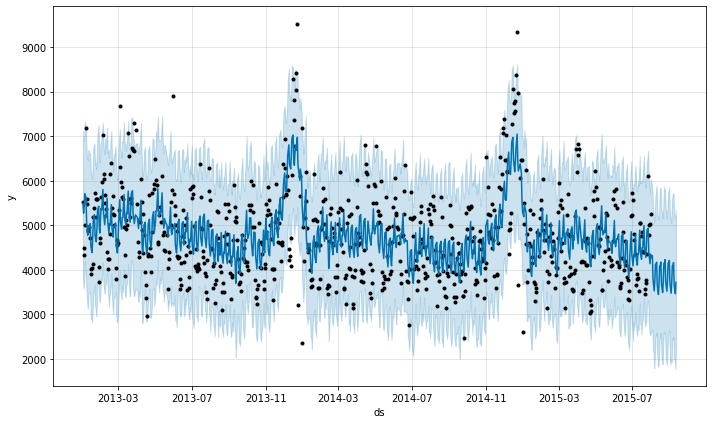

In [102]:
model.plot(forecast)
plt.show()

<p>The black dots plots is the observed values of our time series, blue line represent the forecasted values and the blue shaded regions is for the uncertainty intervals of our forecasts. As we see Prophet catches the trends and most of the time gets future values right.</p>

<p>One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manyally included holidayes contribute to the overall forecasted values:</p>

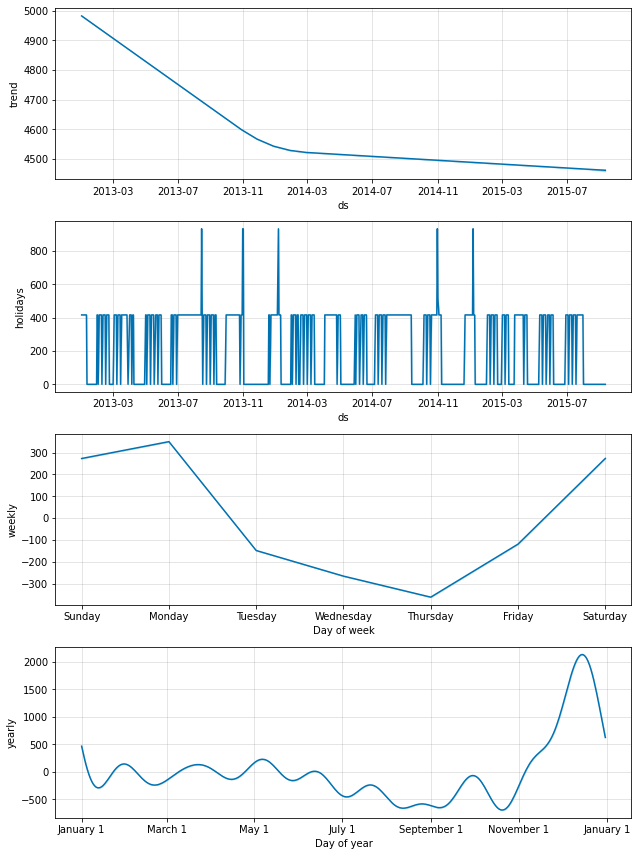

In [107]:
model.plot_components(forecast)

<p>The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time. The second graph shows the holiays gaps. The third plot is for the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.</p>

In [110]:
forecast = forecast[['ds', 'yhat']].rename(columns = {'ds':'Data', 'yhat':'Forecast'})
forecast.head()

,Data,Forecast
0,2013-01-02,5480.036913
1,2013-01-03,5270.349363
2,2013-01-04,5408.989513
3,2013-01-05,5707.317953
4,2013-01-07,5629.713614


<h3 id='13'>Conclusion of Time Series forecasting</h3>
<p>In conclusion section, I will present main advantages and drawbacks of time series forecasting:</p>
<p><i><b>Advantages</b></i></p>
<ul>
    <li>A powerful tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays</li>
</ul>
<p><i><b>Drawbacks</b></i></p>
<ul>
    <li>Doesn't catch interactions between external features</li>
    <li>Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the biggest drawback for new companies.</li>
</ul>